# <p style="color:red">Dynamic Models for Building Energy Management.</p>

*Noémie Vauthier/ Roméo Viel / Perrine Julien / Marine Phalippon*

*students at Grenoble INP - ENSE3 '2A-SEM-G2'*

*date: 2022/06/07*


## <p style="color:blue"> Contents </p>

    - 1. Description of the building
    - 2. Hypothesis: location, boundary conditions, schedule for usage, etc.
    - 3. Thermal model
    - 4. Mathematical model 
    - 5. Results

## <p style="color:blue"> 1. Description of the building </p>

The "École Nationale Supérieure d'Informatique et de Mathématiques Appliquées" (Grenoble INP - Ensimag) is equipped with a data center. This data center is located in a larger building.  

The area under consideration consists of two rooms. The data center, which represents an important heat source, is located in the larger room. This large room also includes a ventilation system (and six air outlets on walls 5 and 6). 

Our zone has 8 different walls: 
- 1 : separation with an interior room
- 2 : border with the outside air including many windows 
- 3: border with the outside air
- 4 : communicates with a corridor 
- 5 : border between the small room and the big room with a door 
- 6 : border between the small room and the big room with different proprieties of the wall 5
- 7 : separation with an interior room with different proprieties of the wall 1
- 8: connection with a corridor with different properties of wall 4
    
We have all the thermal data of this room as well as all the parameters of the walls and the power of the data processing center. This room seemed particularly interesting to model because it is a real case. 

![Building3D](Building3D.png)
> 3D scheme of the real building

## <p style="color:blue"> 2. Hypothesis </p>

All the walls are originally different (materials, thickness) but we decide in order to simplify the problem to gather wall 7 and 4 in one wall ("wall4") because they have similar properties and are both in contact with the corridor. We do the same with walls 5 and 6 ("wall5"). 

We also remove the openings on wall 5 to simplify the modeling. We decide at first not to take into account the ventilation system. 

The wall 4 being in contact with a room which has a similar temperature with the one of the data center, the thermal exchanges by the wall are small, we decide to consider this wall as adiabatic. This assumption is very strong because this wall will not appear in the thermal modeling. 

For wall 2, we consider that the numerous windows are only one large window. 

The last simplifying assumption is in the composition of the walls. In the real case, the walls are composed of 3 layers of materials. But we decide to consider only one layer of building materials and one layer of insulation. 

- Interior/interior wall: the second layer of BA13 is neglected because its thickness is low. This leads to take into account a wall composed of BA13 and air. 
- Exterior/interior wall: we take into account the construction layer because it is the thickest layer as well as the insulation. Indeed, these are the two layers that are the most resistant to heat flow. The BA13 layer is neglected. 
	
Finally, we have the following scheme: 
![Building](Building1.png)
> 2D scheme for the modelisation of the building

Our subject is a real case, which has been studied by a team member in another project. Therefore, we did not have to make any assumptions about wall thicknesses or boundary conditions (e.g. corridor temperature). Indeed, these are data that have been measured before. Also, the power of the data center is known and is 10 000W. 


## <p style="color:blue"> 3. Thermal model </p>
In a first step, we made a first diagram of our problem by hand:
![Thermal_scheme](Thermal_scheme.png)
>Thermal scheme of our problem

The problem represented here is the unoptimized one (without ventilation).

The two temperatures we wanted to know are Ө20 and Ө21.

We have modeled each wall with six resistances: 
- A first convective resistor representing the air/external wall interface.
- A radiation flow arriving between the convective and conductive resistor to model the solar radiation arriving on the exterior wall
- Two resistors representing the wall, with a node in the middle to model the storage capacity of the wall
- Two resistors representing the insulation, with a node in the middle to model the storage capacity of the wall
- Another radiation flux arriving between the convective and conductive resistor to model the solar radiation arriving on the - interior wall
- A convective resistance representing the interface insulator / interior air

Before each wall, we have a temperature source, representing either the outdoor temperature T0, a room temperature Ө20 or Ө21, or the corridor temperature Th.

The window and doors are simply modeled by a resistance between a temperature source and the room temperature. For the small room, the door resistance parallels the wall modeling.

The ability of the main room to store heat is modeled by a capacitor.

The data center, the heat source, is modeled by a heat flow arrival.

Finally, our initial problem has 22 nodes (nq = 22), 27 flows (nθ = 27) and 8 branches.

### <p style="color:orange"> 3.1 Description of the walls</p>
First, we described the properties of the materials we used. They have different properties (density, specific heat, conductivity) :

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

# Variables 
Va = 107.3 #Volume of the room
σ = 5.67e-8 # W/m².K⁴ Stefan-Bolzmann constant
ε_wLW = 0.9 # long wave wall emmisivity (concrete)
α_wSW = 0.2 # absortivity white surface
ε_gLW = 0.9 # long wave glass emmisivity (glass pyrex)
τ_gSW = 0.83 # short wave glass transmitance (glass)
α_gSW = 0.1 # short wave glass absortivity

# Physical properties
material = {'Conductivity': [1.75, 0.25, 0.04, 0.952, 0.024, 0.2, 0.065],
        'Density': [2500.0, 825, 18, 1185, 1, 800, 2500],
        'Specific heat': [1008, 1008, 1030, 1080, 1005, 2385, 720]}

material = pd.DataFrame(material, index=['beton arme', 'BA13', 'laine de verre', 'parpaing de ciment', 'air', 'bois lourd','verre'])
print("\n materials \n", material)



 materials 
                     Conductivity  Density  Specific heat
beton arme                 1.750   2500.0           1008
BA13                       0.250    825.0           1008
laine de verre             0.040     18.0           1030
parpaing de ciment         0.952   1185.0           1080
air                        0.024      1.0           1005
bois lourd                 0.200    800.0           2385
verre                      0.065   2500.0            720


Each wall has different properties (material, thickness,…). We choose to make dictionaries in order to be able to easily select the information of each wall. The properties of each wall are detailed in our code below : 

In [31]:
# Constantes

h=pd.DataFrame([{'in':4., 'out':10}])

# air inside the room

air = {'Density': 1.2,
       'Specific heat': 1000}


wall1 = {'Conductivity': [material['Conductivity'][1], material['Conductivity'][4], material['Conductivity'][1]],
        'Density': [material['Density'][1], material['Density'][4], material['Density'][1]],
        'Specific heat': [material['Specific heat'][1], material['Specific heat'][4], material['Specific heat'][1]],
        'Width': [0.0125, 0.108, 0.0125],
        'Surface': 9.8046}

wall1 = pd.DataFrame(wall1, index=['BA13', 'air', 'BA13'])

print("\n wall1 \n", wall1)

wall2 = {'Conductivity': [material['Conductivity'][3], material['Conductivity'][2], material['Conductivity'][1]],
        'Density': [material['Density'][3], material['Density'][2], material['Density'][1]],
        'Specific heat': [material['Specific heat'][3], material['Specific heat'][2], material['Specific heat'][1]],
        'Width': [0.2, 0.283-0.2-0.0125, 0.0125],
        'Surface': 23.8602-8.3232}

wall2 = pd.DataFrame(wall2, index=['parpaing de ciment', 'laine de verre', 'BA13'])

print("\n wall2 \n", wall2)

wall3 = {'Conductivity': [material['Conductivity'][0], material['Conductivity'][2], material['Conductivity'][1]],
        'Density': [material['Density'][0], material['Density'][2], material['Density'][1]],
        'Specific heat': [material['Specific heat'][0], material['Specific heat'][2], material['Specific heat'][1]],
        'Width': [0.35, 0.429-0.35-0.0125, 0.0125],
        'Surface': 14.7966}

wall3 = pd.DataFrame(wall3, index=['beton arme', 'laine de verre', 'BA13'])

print("\n wall3 \n", wall3)

wall4 = {'Conductivity': [material['Conductivity'][0], material['Conductivity'][2], material['Conductivity'][1]],
        'Density': [material['Density'][0], material['Density'][2], material['Density'][1]],
        'Specific heat': [material['Specific heat'][0], material['Specific heat'][2], material['Specific heat'][1]],
        'Width': [0.35, 0.429-0.35-0.0125, 0.0125],
        'Surface': 9.1312-2.7248}

wall4 = pd.DataFrame(wall4, index=['beton arme', 'laine de verre', 'BA13'])

print("\n wall4 \n", wall4)

wall5 = {'Conductivity': [material['Conductivity'][1], material['Conductivity'][4], material['Conductivity'][1]],
        'Density': [material['Density'][1], material['Density'][4], material['Density'][1]],
        'Specific heat': [material['Specific heat'][1], material['Specific heat'][4], material['Specific heat'][1]],
        'Width': [0.0125, (0.094-2*0.0125+0.133-2*0.0125)/2, 0.0125],
        'Surface': 4.94-2.01564+14.703}

wall5 = pd.DataFrame(wall5, index=['BA13', 'isolant', 'BA13'])

print("\n wall5 \n", wall5)



 wall1 
       Conductivity  Density  Specific heat   Width  Surface
BA13         0.250    825.0           1008  0.0125   9.8046
air          0.024      1.0           1005  0.1080   9.8046
BA13         0.250    825.0           1008  0.0125   9.8046

 wall2 
                     Conductivity  Density  Specific heat   Width  Surface
parpaing de ciment         0.952   1185.0           1080  0.2000   15.537
laine de verre             0.040     18.0           1030  0.0705   15.537
BA13                       0.250    825.0           1008  0.0125   15.537

 wall3 
                 Conductivity  Density  Specific heat   Width  Surface
beton arme              1.75   2500.0           1008  0.3500  14.7966
laine de verre          0.04     18.0           1030  0.0665  14.7966
BA13                    0.25    825.0           1008  0.0125  14.7966

 wall4 
                 Conductivity  Density  Specific heat   Width  Surface
beton arme              1.75   2500.0           1008  0.3500   6.4064
lain

### <p style="color:orange"> 3.1 Description of doors and windows</p>
We also model doors and windows : 

In [32]:
entrydoor = {'Conductivity': material['Conductivity'][5],
        'Density': material['Density'][5],
        'Specific heat': material['Specific heat'][5],
        'Width': 0.04,
        'Surface': 2.7248}

storagedoor = {'Conductivity': material['Conductivity'][5],
        'Density': material['Density'][5],
        'Specific heat': material['Specific heat'][5],
        'Width': 0.039,
        'Surface': 2.01564}

window = {'Conductivity': material['Conductivity'][6],
        'Density': material['Density'][6],
        'Specific heat': material['Specific heat'][6],
        'Width': 0.015,
        'Surface': 8.3232}
print("\n entrydoor \n", entrydoor)
print("\n storagedoor \n", storagedoor)
print("\n window \n", window)


 entrydoor 
 {'Conductivity': 0.2, 'Density': 800.0, 'Specific heat': 2385, 'Width': 0.04, 'Surface': 2.7248}

 storagedoor 
 {'Conductivity': 0.2, 'Density': 800.0, 'Specific heat': 2385, 'Width': 0.039, 'Surface': 2.01564}

 window 
 {'Conductivity': 0.065, 'Density': 2500.0, 'Specific heat': 720, 'Width': 0.015, 'Surface': 8.3232}


## <p style="color:blue"> 4. Mathematical model </p>
### <p style="color:orange"> 4.1 Calculation of A matrix </p>
First, we decided to plot the matrix A.It shows how the temperature nodes are connected by branches of heat flow. It consists of nq rows and  nθ columns, where nq  is the number of flow branches and nθ is the number of temperature nodes. If flow m enters into the node n, then the element (m, n) is 1; if flow m exits from the node n, then the element (m, n) is -1; if flow m is not conected to node n, then the element (m, n) is 0.

According to our resistance diagram, we can build the matrix A :
![A](Amatrix.png)
> A matrix 

In [33]:
#Calcul des matrices

#Code matrice A
A=np.zeros([27,22])
A[0,0]=1
A[1,0],A[1,1]=-1,1
A[2,1],A[2,2]=-1,1
A[3,2],A[3,3]=-1,1
A[4,3],A[4,4]=-1,1
A[5,4],A[5,20]=-1,1
A[1,0],A[1,1]=-1,1

A[6,5]=1
A[7,5],A[7,6]=-1,1
A[8,6],A[8,7]=-1,1
A[9,7],A[9,8]=-1,1
A[10,8],A[10,9]=-1,1
A[11,9],A[11,20]=-1,1

A[12,10]=1
A[13,10],A[13,11]=-1,1
A[14,11],A[14,12]=-1,1
A[15,12],A[15,13]=-1,1
A[16,13],A[16,14]=-1,1
A[17,14],A[17,20]=-1,1
A[18,15],A[18,20]=-1,1

A[19,15],A[19,16]=-1,1
A[20,16],A[20,17]=-1,1
A[21, 17], A[21, 18] = -1, 1
A[22,18],A[22,19]=-1,1
A[23,19],A[23,21]=-1,1
A[24,20],A[24,21]=-1,1
A[25,20]=1
A[26,20]=1

#print(A) #to see the python result

### <p style="color:orange"> 4.2 Calculation of matrix G </p>
The conductance matrix G is the diagonal matrix containing the conductances. Its size is It consists of nq*nq.

In [34]:
G=np.zeros([27,27])

For the conduction resistances, we have: G=conductivity/(surface*thickness). For the convective conductance we have G=Air convection coefficient *surface. The convection coefficient of the air is different inside and outside. 
For the doors and windows, we take into account the convection and conduction resitance in the same value of conductance. 

It is needed to calculate every conductance for every wall, door and window, to build G: 

In [35]:
#Calcul des conductance de conduction par mur :
    
#Wall 2
G[0,0]=h['out']*wall2['Surface'][0]
G[1,1]=wall2['Conductivity'][0]/(((wall2['Width'][0])/2)*wall2['Surface'][0]) 
G[2,2]=G[1,1]
G[3,3]=wall2['Conductivity'][1]/(((wall2['Width'][1])/2)*wall2['Surface'][1])
G[4,4]=G[3,3]
G[5,5]=h['in']*wall2['Surface'][0]

#Wall 3
G[6,6]=h['out']*wall3['Surface'][0]
G[7,7]=wall3['Conductivity'][0]/(((wall3['Width'][0])/2)*wall3['Surface'][0])
G[8,8]=G[7,7]
G[9,9]=wall3['Conductivity'][1]/(((wall3['Width'][1])/2)*wall3['Surface'][1])
G[10,10]=G[9,9]
G[11,11]=h['in']*wall3['Surface'][0]

#Wall 4
G[12,12]=h['out']*wall4['Surface'][0]
G[13,13]=wall4['Conductivity'][0]/(((wall4['Width'][0])/2)*wall4['Surface'][0])
G[14,14]=G[13,13]
G[15,15]=wall4['Conductivity'][1]/(((wall4['Width'][1])/2)*wall4['Surface'][1])
G[16,16]=G[15,15]
G[17,17]=h['in']*wall4['Surface'][0]

#Wall 5
G[18,18]=h['out']*wall5['Surface'][0]
G[19,19]=wall5['Conductivity'][0]/(((wall5['Width'][0])/2)*wall5['Surface'][0])
G[20,20]=G[19,19]
G[21,21]=wall4['Conductivity'][1]/(((wall5['Width'][1])/2)*wall5['Surface'][1])
G[22,22]=G[21,21]
G[23,23]=h['in']*wall4['Surface'][0]

#Door
G[24,24]=1/(1/(h['in']*entrydoor['Surface']))+1/(entrydoor['Conductivity']/((entrydoor['Width'])*entrydoor['Surface']))         
G[25,25]=1/(1/(h['in']*storagedoor['Surface']))+1/(storagedoor['Conductivity']/((storagedoor['Width'])*storagedoor['Surface']))


#window
G[26,26]=1/(1/(h['in']*window['Surface']))+1/(window['Conductivity']/((window['Width'])*window['Surface']))

print(G)

[[1.55370000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.12730900e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.12730900e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00

### <p style="color:orange"> 4.3 Calculation of vector b </p>

b is the temperature source vector: if there is no temperature source on the branch m, then bm=0.
![b](b.png)
> matrice b <

On python: 

In [36]:
#matrice b
T0= 19.5
TH= 16.4

b = np.zeros(27)

b[0]=b[6]=b[26]=T0
b[12]=b[25]=TH
print(b)

[19.5  0.   0.   0.   0.   0.  19.5  0.   0.   0.   0.   0.  16.4  0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  16.4 19.5]


### <p style="color:orange"> 4.4 Calculation of C matrix </p>
C is the capacity matrix, a diagonal matrix containing the capacities. If there is no capacity in the node n, then  Cn,n=0.
The capacities are equal to the density of the material * the volume (so surface * width).
Each material have different capacities so each wall have 2 capacities ( 3 in reality but we don't take into acount the last one, see the hypthesis)

Finally on python: 

In [37]:
#Calcul de C
C2 = wall2['Density'] * wall2['Specific heat'] * wall2['Surface'] * wall2['Width'] #capacities of the wall 2 
C3 = wall3['Density'] * wall3['Specific heat'] * wall3['Surface'] * wall3['Width']
C4 = wall4['Density'] * wall4['Specific heat'] * wall4['Surface'] * wall4['Width']
C5 = wall5['Density'] * wall5['Specific heat'] * wall5['Surface'] * wall5['Width']
Cair = air['Density'] * air['Specific heat'] * Va


For exemple for the wall 2 we have: 

In [38]:
print (C2)

parpaing de ciment    3.976851e+06
laine de verre        2.030795e+04
BA13                  1.615071e+05
dtype: float64


We compute the total C matrix: 
The first value of C equal zero beacause node 0 haven't capacity but the second have the value of the capcity of the node 1 (second node)... The capacity of the node 1 equal to the capacity of the part of the wall 2 with the material "parpaing ciment". And so one. 

In [39]:
C = np.diag([0, C2[0], 0, C2[1], 0, 0, C3[0], 0, C3[1], 0, 0, C4[0], 0, C4[1], 0, 0, C5[0], 0, C5[1], 0, Cair, 0])

#print(C) to see the Python result

### <p style="color:orange"> 4.5 Calculation of f vector </p>
f is the heat flow source vector: if there is no heat flow source in the node n, then fn=0.In a first approximation, we give values to the vector f as in our code below. f have nq values.
These values are given arbitrarily except the last one which corresponds to the data center. 

![f](f.png)
> f vetor 

In [40]:
f=np.zeros(22)
f[[0,4,5,9,10,14,20]] = np.array([1000,1000,1000,500,500,500,10000]) 
print(f)

[ 1000.     0.     0.     0.  1000.  1000.     0.     0.     0.   500.
   500.     0.     0.     0.   500.     0.     0.     0.     0.     0.
 10000.     0.]


## <p style="color:blue"> 5. Steady state results </p>

Because of the instability of the solution, we add a proportional corrector in our modeling. This correction translates "in reality" into an HVAC.

### <p style="color: orange"> Impact of the coefficient Kp  </p>

Kp is behaving like a corrector to force the temperature from the HVAC to be the temperature in the room. The higher it is, the closer the temperature of the room will be to the one of the HVAC. That is the goal of a proportional corrector. The only limit there is is that the higher the Kp is, the more powerful the HVAC needs to be. That is why in our simulation we can not have the exact same temperature in the room as the one set in the HVAC. 

### <p style="color: orange"> 5.2 With air conditionning  </p>
#### <p style="color: green"> 5.2.1 Modify the modelisation  </p>
In order to take into account the air conditionning system, we have to modify the modelisation and so matrices. 
- For the termal modelisation, we add a new branche (in red on the following diagram)
![withHVAC.png](withHVAC.png)
> new thermal scheme 

- We add also a new value to the matrices A and b: 
![newAb.png](newAb.png)
> new A matrix and b vector  

- The G matrix has to be change too.The conductance of node 27 equal to Kp 

We have also to modify the Python code of the matrixes: 

In [41]:
# Variables 
Va = 107.3
nb_branches = 28
nb_noeuds = 22

    #Calcul des matrices
#Code matrice A
A = np.zeros([nb_branches,nb_noeuds])
A[0,0]=1
A[1,0],A[1,1]=-1,1
A[2,1],A[2,2]=-1,1
A[3,2],A[3,3]=-1,1
A[4,3],A[4,4]=-1,1
A[5,4],A[5,20]=-1,1
A[1,0],A[1,1]=-1,1

A[6,5]=1
A[7,5],A[7,6]=-1,1
A[8,6],A[8,7]=-1,1
A[9,7],A[9,8]=-1,1
A[10,8],A[10,9]=-1,1
A[11,9],A[11,20]=-1,1

A[12,10]=1
A[13,10],A[13,11]=-1,1
A[14,11],A[14,12]=-1,1
A[15,12],A[15,13]=-1,1
A[16,13],A[16,14]=-1,1
A[17,14],A[17,20]=-1,1
A[18,15],A[18,20]=-1,1

A[19,15],A[19,16]=-1,1
A[20,16],A[20,17]=-1,1
A[21, 17], A[21, 18] = -1, 1
A[22,18],A[22,19]=-1,1
A[23,19],A[23,21]=-1,1
A[24,20],A[24,21]=-1,1
A[25,20]=1
A[26,20]=1
A[27,20]=1

#Code matrice G
G=np.zeros([nb_branches,nb_branches])

#Calcul des conductance de conduction par mur :
    
#Wall 2

G[0,0]=h['out']*wall2['Surface'][0]
G[1,1]=wall2['Conductivity'][0]/(((wall2['Width'][0])/2)*wall2['Surface'][0])
G[2,2]=G[1,1]
G[3,3]=wall2['Conductivity'][1]/(((wall2['Width'][1])/2)*wall2['Surface'][1])
G[4,4]=G[3,3]
G[5,5]=h['in']*wall2['Surface'][0]

#Wall 3

G[6,6]=h['out']*wall3['Surface'][0]
G[7,7]=wall3['Conductivity'][0]/(((wall3['Width'][0])/2)*wall3['Surface'][0])
G[8,8]=G[7,7]
G[9,9]=wall3['Conductivity'][1]/(((wall3['Width'][1])/2)*wall3['Surface'][1])
G[10,10]=G[9,9]
G[11,11]=h['in']*wall3['Surface'][0]

#Wall 4

G[12,12]=h['out']*wall4['Surface'][0]
G[13,13]=wall4['Conductivity'][0]/(((wall4['Width'][0])/2)*wall4['Surface'][0])
G[14,14]=G[13,13]
G[15,15]=wall4['Conductivity'][1]/(((wall4['Width'][1])/2)*wall4['Surface'][1])
G[16,16]=G[15,15]
G[17,17]=h['in']*wall4['Surface'][0]

#Wall 5

G[18,18]=h['out']*wall5['Surface'][0]
G[19,19]=wall5['Conductivity'][0]/(((wall5['Width'][0])/2)*wall5['Surface'][0])
G[20,20]=G[19,19]
G[21,21]=wall4['Conductivity'][1]/(((wall5['Width'][1])/2)*wall5['Surface'][1])
G[22,22]=G[21,21]
G[23,23]=h['in']*wall4['Surface'][0]

# Door
G[24,24]=1/(1/(h['in']*entrydoor['Surface']))+1/(entrydoor['Conductivity']/((entrydoor['Width'])*entrydoor['Surface']))      
G[25,25]=1/(1/(h['in']*storagedoor['Surface']))+1/(storagedoor['Conductivity']/((storagedoor['Width'])*storagedoor['Surface']))


# window
G[26,26]=1/(1/(h['in']*window['Surface']))+1/(window['Conductivity']/((window['Width'])*window['Surface']))

# HVAC
Kp = 1000
G[27,27] = Kp

#matrice b
T0 = 19.5
TH = 16.4
Tventil = 20.0
b = np.zeros(nb_branches)

b[0] = b[6] = b[26] = T0
b[12] = b[25] = TH
b[27] = Tventil
#b[[0, 6, 12]]= 1

σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant
ε_wLW = 0.9     # long wave wall emmisivity (concrete)
α_wSW = 0.2     # absortivity white surface
ε_gLW = 0.9     # long wave glass emmisivity (glass pyrex)
τ_gSW = 0.83    # short wave glass transmitance (glass)
α_gSW = 0.1     # short wave glass absortivity


#Calcul de C
C2 = wall2['Density'] * wall2['Specific heat'] * wall2['Surface'] * wall2['Width']
C3 = wall3['Density'] * wall3['Specific heat'] * wall3['Surface'] * wall3['Width']
C4 = wall4['Density'] * wall4['Specific heat'] * wall4['Surface'] * wall4['Width']
C5 = wall5['Density'] * wall5['Specific heat'] * wall5['Surface'] * wall5['Width']
Cair = air['Density'] * air['Specific heat'] * Va

C = np.diag([0, C2[0], 0, C2[1], 0, 0, C3[0], 0, C3[1], 0, 0, C4[0], 0, C4[1], 0, 0, C5[0], 0, C5[1], 0, Cair, 0])


# #matrice f
# f=np.zeros(22)
# f[[0,4,5,9,10,20]] = np.array([1000,1000,1000,500,500,4000])
# #f[[0,4,5,9,10,20]] = 1
# #vecteur y
# y=np.ones(22)

f=np.zeros(nb_noeuds)

f[[0,4,5,9,10,14,20]] = np.array([1000,1000,1000,500,500,500,4000])

## <p style="color:blue"> 4. Results </p>
### <p style="color:orange"> 4.1 Steady-state results </p>
We compute the vectors u and y needed to solve the problem:

In [44]:
y = np.ones(nb_noeuds)
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

We can then solve the problem in steady state:

In [45]:
### State Space Model ###
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
  {max(abs(yss - ytc)):.2e}')


[25.94  26.783 27.627 34.705 41.783 26.26  26.684 27.107 30.625 34.144
 24.232 25.355 26.478 35.811 45.144 25.7   25.7   25.7   25.7   25.7
 25.7   25.7  ]
[25.94  26.783 27.627 34.705 41.783 26.26  26.684 27.107 30.625 34.144
 24.232 25.355 26.478 35.811 45.144 25.7   25.7   25.7   25.7   25.7
 25.7   25.7  ]
Max error in steady-state between thermal circuit and state-space:  6.08e-11


The maximal error between thermal circuit and state-space model is very low, it shows that we can use the state-space model to modelize the system.

### <p style="color:orange"> 4.2 Dynamic simulation</p>

We modified the output vector y to select only the desired temperatures inside the 2 rooms.

In [46]:
y = np.zeros(nb_noeuds)
y[[20,21]] = 1
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u

print(np.array_str(yss, precision=3, suppress_small=True))


[25.7 25.7]


We get 25.7°c in the rooms, which is logical.

### <p style="color:orange"> 4.3 Time step </p>

We calculated the maximum time step for numerical stability of Euler explicit integration in time. Thanks to this result, we choose to use a time step of 50s.


In [47]:
dtmax = min(-2./np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

dt = 50


Maximum time step: 246.12 s


### <p style="color:orange"> 4.4 Step response </p>

We tested the step response by comparing Euler implicit and explicit.

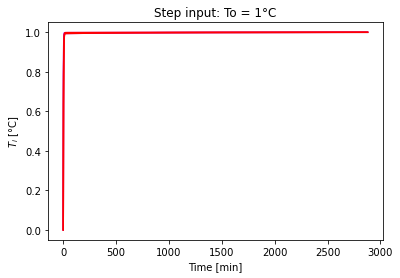

In [48]:
duration = 3600 * 24 * 2

# Number of steps
n = int(np.floor(duration/dt))
t = np.arange(0,n*dt,dt) #time

# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
u = np.zeros([13, n])
u[0:6, :] = np.ones([6, n])

temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])
       

y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

fig, ax = plt.subplots()

ax.plot(t/60, y_exp.T, color='m')
ax.plot(t/60, y_imp.T, color='r')
ax.set(xlabel='Time [min]',
        ylabel='$T_i$ [°C]',
        title='Step input: To = 1°C')
plt.show()



More precisly, we have :

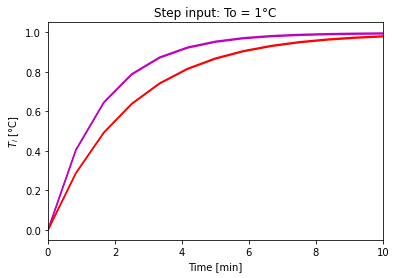

In [49]:
fig, ax = plt.subplots()
ax.set_xlim(0, 10)
ax.plot(t/60, y_exp.T, color='m')
ax.plot(t/60, y_imp.T, color='r')
ax.set(xlabel='Time [min]',
        ylabel='$T_i$ [°C]',
        title='Step input: To = 1°C')
plt.show()

The Euler explicit method is faster, so we used this one.

In [50]:
b = np.zeros(nb_branches)

b[0] = b[6] = b[26] = 1
b[12] = b[25] = 1
b[27] = 1

f=np.zeros(nb_noeuds)

ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {ytc[20]:.4f} °C')
print('- response to step input:', y_exp[0,len(y_exp[0])-1], '°C')


Steady-state indoor temperature obtained with:
- DAE model: 1.0000 °C
- response to step input: 0.9995684310700272 °C


### <p style="color:orange"> 4.5 Simulation </p>

We initialize again the model : 

In [51]:
b = np.zeros(nb_branches)

b[0] = b[6] = b[26] = T0
b[12] = b[25] = TH
b[27] = Tventil

f=np.zeros(nb_noeuds)

f[[0,4,5,9,10,14,20]] = np.array([1000,1000,1000,500,500,500,4000])

#f[[0,4,5,9,10,20]] = 1

#vecteur y
#y = np.ones(nb_noeuds)
y[[20,21]] = 1


#vecteur u
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

We implement the weather information of the place, i.e. Grenoble :


In [61]:
b = np.zeros(nb_branches)

b[0] = b[6] = b[26] = T0
b[12] = b[25] = TH
b[27] = Tventil

f=np.zeros(nb_noeuds)

f[[0,4,5,9,10,14,20]] = np.array([1000,1000,1000,500,500,500,4000])

#f[[0,4,5,9,10,20]] = 1

#vecteur y
#y = np.ones(nb_noeuds)
y[[20,21]] = 1


#vecteur u
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)



filename = 'FRA_AR_Grenoble.Alpes.Isere.AP.074860_TMYx.2004-2018.epw'
start_date = '2017-07-03 12:00:00'
end_date = '2017-08-05 18:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2017))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

surface_orientation2 = {'slope': 90,
                        'azimuth': 0,
                        'latitude': 45}
albedo = 0.5
rad_surf2 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation2, albedo)
rad_surf2['Qray0'] = rad_surf2.sum(axis=1)

surface_orientation3 = {'slope': 90,
                        'azimuth': 270,
                        'latitude': 45}
albedo = 0.5
rad_surf3 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation3, albedo)
rad_surf3['Qray5'] = rad_surf3.sum(axis=1)

data = pd.concat([weather['temp_air'], rad_surf2['Qray0'],rad_surf3['Qray5']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'T0'})


data['Tventil'] = 20 * np.ones(data.shape[0])
data['TH'] = 16.4 * np.ones(data.shape[0])
data['Q4'] = 1000 * np.ones(data.shape[0])
data['Q9'] = 500 * np.ones(data.shape[0])
data['Q10'] = 500 * np.ones(data.shape[0])
data['Q14'] = 500 * np.ones(data.shape[0])
data['Q20'] = 4000 * np.ones(data.shape[0])

t = dt * np.arange(data.shape[0])

u = pd.concat([data['T0'], data['T0'], data['T0'],data['TH'],data['TH'], data['Tventil'],
                α_wSW * wall2['Surface']['parpaing de ciment'] * data['Qray0'],  data['Q4']
                ,α_wSW * wall3['Surface']['beton arme'] * data['Qray5'], data['Q9'], data['Q10'], data['Q14'], data['Q20']], axis=1)

temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Tventil'] - y_exp[0, :])



![Result](285563206_504359888142543_3439487882525590915_n.png)
> Result with consideration of the weather

We can see on this figure that the temperature of the rooms varies well according to the weather data. We also see that the ventilation is set up to regulate the temperature of the rooms. This shows that our simulation takes into account the weather data, but also that the temperature control is functional.

## <p style="color:blue"> Conclusion </p>

After modeling our building and making a number of assumptions, we were able to develop a simulation to try to find out the temperature in the center of the two rooms. 
It is quite simple to obtain a result in steady state. However, when we want to have a dynamic model, it is necessary to bring a correction (modeled here by a ventilation).
It is then possible to realize the dynamic model, but also to take into account external meteorological data, to model our rooms in Grenoble for example.

We learned during this work to make complex thermal diagrams, to make the necessary hypotheses for our model, and to code a dynamic simulation allowing to study the behavior of certain parts with respect to certain meteorological conditions.
